In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from urllib.parse import urljoin

In [3]:
def fetch_consumer_confidence(page=1, typeid=1):
    base_url = 'https://cebf.utcc.ac.th/'
    target_url = f'{base_url}index_number.php?page={page}&typeid={typeid}'
    resp = requests.get(target_url)
    resp.raise_for_status()

    soup = BeautifulSoup(resp.content, 'html.parser')

    # Locate the main table. this site usually using just plain tr td which is very hard to match.
    # However, we can find the table head (td) which has class of bg-green and txt_white and we will select the tbody which is parent of parent of this td
    web_table_header = soup.select('td.txt_white.bg_green')
    # get header text
    headers = [x.text for x in web_table_header]
    # print(f'Headers extracted from table: {headers}')

    # Now we will select parent of parent which is a tbody element. this tbody element contain all information of the table
    web_table = web_table_header[0].parent.parent # doesn't matter of the order of headers. in this case we use 0
    print(type(web_table))


    # Parsing the table
    # we will selected all of tr element in table
    entries = web_table.find_all('tr')[1:] # remove index 0 as that is a headers
    print(f'size of table (with headers removed): {len(entries)}') # this should match with the length of column in the web

    # Looping each entries to get the value of each columns
    data = []
    for row in entries:
        col = row.find_all('td')
        try:
            if len(col) != 3: # should be 3
                raise Exception('Column size is not equal to 3. there might be something wrong with the table parsing')
            
            date_month_year = col[0].text
            topic = col[1].text
            href = col[2].find('a')['href']
            download_link = urljoin(base_url, href)

            data.append(
                dict(zip(headers, [date_month_year, topic, download_link]))
            )

        except Exception as e:
            print(f"An error of type {type(e).__name__} occurred: {e}")
    if data:
        return pd.DataFrame(data, columns=headers)
    else:
        raise Exception('Data is null')
        return None
    
def batch_download_consumer_confidence(number_of_pages: int):
    final_data = pd.DataFrame()
    pages = [i for i in range(1,number_of_pages+1)]
    for page in pages:
        df = fetch_consumer_confidence(page=page)
        final_data = pd.concat([final_data, df], ignore_index=True)

    return final_data
        

In [4]:
# df = fetch_consumer_confidence()
# display(df)

df = batch_download_consumer_confidence(number_of_pages=13) # only 13 pages as of Sep 2, 2025

<class 'bs4.element.Tag'>
size of table (with headers removed): 20
<class 'bs4.element.Tag'>
size of table (with headers removed): 20
<class 'bs4.element.Tag'>
size of table (with headers removed): 20
<class 'bs4.element.Tag'>
size of table (with headers removed): 20
<class 'bs4.element.Tag'>
size of table (with headers removed): 20
<class 'bs4.element.Tag'>
size of table (with headers removed): 20
<class 'bs4.element.Tag'>
size of table (with headers removed): 20
<class 'bs4.element.Tag'>
size of table (with headers removed): 20
<class 'bs4.element.Tag'>
size of table (with headers removed): 20
<class 'bs4.element.Tag'>
size of table (with headers removed): 20
<class 'bs4.element.Tag'>
size of table (with headers removed): 20
<class 'bs4.element.Tag'>
size of table (with headers removed): 20
<class 'bs4.element.Tag'>
size of table (with headers removed): 20


In [6]:
df.to_csv('../CCI_report/cci_data_table.csv', index=False, encoding='utf-8-sig')

# Download from table

In [7]:
import os
import requests
import zipfile
import glob
from PyPDF2 import PdfMerger
import shutil
import time
import random

In [8]:
# check if df is initialize in this session
try:
    display(df.head())
    print('df is already initialized in this session')
except Exception as e:
    df = pd.read_csv('../CCI_report/cci_data_table.csv', encoding='utf-8-sig')
    print('df is not initialized yet, initized df')
    display(df.head())




,วันที่เผยแพร่,หัวข้อผลสำรวจ,ดาวน์โหลด
0,สิงหาคม 2568,ดัชนีความเชื่อมั่นของผู้บริโภคประจำเดือนกรกฎาค...,https://cebf.utcc.ac.th/upload/index_file/file...
1,กรกฎาคม 2568,ดัชนีความเชื่อมั่นของผู้บริโภคประจำเดือนมิถุนา...,https://cebf.utcc.ac.th/upload/index_file/file...
2,มิถุนายน 2568,ดัชนีความเชื่อมั่นของผู้บริโภคประจำเดือนพฤษภาค...,https://cebf.utcc.ac.th/upload/index_file/file...
3,พฤษภาคม 2568,ดัชนีความเชื่อมั่นของผู้บริโภคประจำเดือนเมษายน...,https://cebf.utcc.ac.th/upload/index_file/file...
4,เมษายน 2568,ดัชนีความเชื่อมั่นของผู้บริโภคประจำเดือนมีนาคม...,https://cebf.utcc.ac.th/upload/index_file/file...


df is already initialized in this session


In [9]:
df[df['ดาวน์โหลด'].str.contains('zip')]

,วันที่เผยแพร่,หัวข้อผลสำรวจ,ดาวน์โหลด
168,มีนาคม 2559,ดัชนีความเชื่อมั่นผู้บริโภค ประจำเดือนกุมภาพัน...,https://cebf.utcc.ac.th/upload/index_file/file...
169,กุมภาพันธ์ 2559,ดัชนีความเชื่อมั่นผู้บริโภค ประจำเดือนมกราคม 2559,https://cebf.utcc.ac.th/upload/index_file/file...
170,มกราคม 2559,ดัชนีความเชื่อมั่นผู้บริโภค ประจำเดือนธันวาคม ...,https://cebf.utcc.ac.th/upload/index_file/file...
171,ธันวาคม 2558,ดัชนีความเชื่อมั่นผู้บริโภค ประจำเดือนพฤศจิกาย...,https://cebf.utcc.ac.th/upload/index_file/file...
172,พฤศจิกายน 2558,ดัชนีความเชื่อมั่นผู้บริโภค ประจำเดือนตุลาคม2558,https://cebf.utcc.ac.th/upload/index_file/file...
173,ตุลาคม 2558,ดัชนีความเชื่อมั่นผู้บริโภค ประจำเดือนกันยายน ...,https://cebf.utcc.ac.th/upload/index_file/file...
174,กันยายน 2558,ดัชนีความเชื่อมั่นผู้บริโภค ประจำเดือนสิงหาคม ...,https://cebf.utcc.ac.th/upload/index_file/file...
175,สิงหาคม 2558,ดัชนีความเชื่อมั่นผู้บริโภค ประจำเดือนกรกฏาคม ...,https://cebf.utcc.ac.th/upload/index_file/file...
176,สิงหาคม 2558,ดัชนีความเหมาะสมในการใช้จ่าย ประจำเดือนกรกฎาคม...,https://cebf.utcc.ac.th/upload/index_file/file...
177,กรกฎาคม 2558,ดัชนีความเชื่อมั่นผู้บริโภค ประจำเดือนมิถุนายน...,https://cebf.utcc.ac.th/upload/index_file/file...


In [16]:
# there are two case of downloading file from the website
# 1. the file is just a single .pdf file --> download and save single pdf
# 2. the file is a zip that cotain multiple .pdf files --> download zip --> extract --> merge to pdf
# df[df['ดาวน์โหลด'].str.contains('zip')]


def download_file(df: pd.DataFrame, dir: str) -> dict: # return stat of successful / failed downloads
    time.sleep(random.randint(2,5))
    stat = {
        'success': 0,
        'failed': 0
    }
    file_to_download = dict(zip(df['หัวข้อผลสำรวจ'].values.tolist(), df['ดาวน์โหลด'].values.tolist()))

    tmp_path = './tmp/'
    def handle_tmp_dir(tmp_path: str,file_name: str) -> str:
        try:
            new_tmp_path = os.path.join(tmp_path,file_name)
            os.makedirs(new_tmp_path, exist_ok=True)
            return new_tmp_path
        except OSError as e:
            print(f'Error creating directory: {e}')
        except Exception as e:
            print(f'Error: {e}')



    try:
        for file_name, url in file_to_download.items():
            res = requests.get(url=url, allow_redirects=True)
            res.raise_for_status() # rasie error if status error

            # handle case for zip and pdf
            ext = url.split('/')[-1:][0].split('.')[1] # extract extension


            if ext == 'pdf': # case of .pdf
                print(f'pdf case for {file_name}')
                print(os.path.join(dir,f'{file_name}.{ext}'))
                with open(os.path.join(dir,f'{file_name}.{ext}'), 'wb') as f:
                    f.write(res.content)

            
            if ext == 'zip': # case of .zip
                new_tmp_path = handle_tmp_dir(tmp_path, file_name)
                with open(os.path.join(new_tmp_path, f'{file_name}.{ext}'), 'wb') as f: # saving zip file to ./tmp/tmp-zipfolder/file.zip
                    f.write(res.content)
                try: 
                    with zipfile.ZipFile(os.path.join(new_tmp_path, f'{file_name}.{ext}'),'r') as zip_ref:
                        zip_ref.extractall(path=new_tmp_path)
                        print(f'Successfully extracted: {file_name}.{ext}')
                except zipfile.BadZipFile:
                    print(f"Error: '{file_name}.{ext}' is not a valid ZIP file.")
                except FileNotFoundError:
                    print(f"Error: ZIP file '{file_name}.{ext}' not found.")
                except Exception as e:
                    print(f"An unexpected error occurred: {e}")
                
                # get all pdfs -> sort file name -> merge to single pdf in dataset folder (not tmp folder)
                pdfs = glob.glob(os.path.join(new_tmp_path, '*.pdf'))
                sorted(pdfs)
                merger = PdfMerger()
                for pdf_file in pdfs:
                    merger.append(pdf_file) # merged pdf files
                with open(os.path.join(dir,f'{file_name}.pdf'), 'wb') as f:
                    merger.write(f)
                merger.close()
                print(f'successfully saved file: {file_name}')

        shutil.rmtree(tmp_path)
        

    except requests.exceptions.RequestException as e:
        print(f"Error downloading file: {e}")
    except IOError as e:
        print(f"Error saving file: {e}")

    return stat


In [17]:


download_file(df=df, dir='../CCI_report/pdfs_report/')
# df.iloc[[0,1,2,3]]

pdf case for ดัชนีความเชื่อมั่นของผู้บริโภคประจำเดือนกรกฎาคม 2568
../CCI_report/pdfs_report/ดัชนีความเชื่อมั่นของผู้บริโภคประจำเดือนกรกฎาคม 2568.pdf
pdf case for ดัชนีความเชื่อมั่นของผู้บริโภคประจำเดือนมิถุนายน 2568
../CCI_report/pdfs_report/ดัชนีความเชื่อมั่นของผู้บริโภคประจำเดือนมิถุนายน 2568.pdf
pdf case for ดัชนีความเชื่อมั่นของผู้บริโภคประจำเดือนพฤษภาคม 2568
../CCI_report/pdfs_report/ดัชนีความเชื่อมั่นของผู้บริโภคประจำเดือนพฤษภาคม 2568.pdf
pdf case for ดัชนีความเชื่อมั่นของผู้บริโภคประจำเดือนเมษายน 2568
../CCI_report/pdfs_report/ดัชนีความเชื่อมั่นของผู้บริโภคประจำเดือนเมษายน 2568.pdf
pdf case for ดัชนีความเชื่อมั่นของผู้บริโภคประจำเดือนมีนาคม 2568
../CCI_report/pdfs_report/ดัชนีความเชื่อมั่นของผู้บริโภคประจำเดือนมีนาคม 2568.pdf
pdf case for ดัชนีความเชื่อมั่นของผู้บริโภคประจำเดือนกุมภาพันธ์ 2568
../CCI_report/pdfs_report/ดัชนีความเชื่อมั่นของผู้บริโภคประจำเดือนกุมภาพันธ์ 2568.pdf
pdf case for ดัชนีความเชื่อมั่นของผู้บริโภคประจำเดือนมกราคม 2568
../CCI_report/pdfs_report/ดัชนีความเช

{'success': 0, 'failed': 0}

In [35]:
ext = 'zip'
os.path.join('../CCI_report/',f'download.{ext}')

'../CCI_report/download.zip'

In [64]:
dict(zip(['a', 'b'], [1,2]))

{'a': 1, 'b': 2}

In [81]:
url = 'https://cebf.utcc.ac.th/upload/index_file/file_th_676d08y2025.pdf'
dir = '/Users/nnloat/phd_rclone/Dataset/CCI_report/pdfs_report/'
res = requests.get(url=url, allow_redirects=True)
res.raise_for_status() # rasie error if status error

with open('/Users/nnloat/phd_rclone/Dataset/CCI_report/pdfs_report/ดัชนีความเชื่อมั่นของผู้บริโภคประจำเดือนกรกฎาคม 2568.pdf', 'wb') as f:
    f.write(res.content)

# Process CCI

In [1]:
import glob
import pandas as pd
import re
from pythainlp.util import thai_strptime
import numpy as np
from datetime import timezone


In [2]:
CCI_files = glob.glob('../CCI_report/pdfs_report/ดัชนีความเชื่อมั่น*ผู้บริโภค*.pdf')
pattern = r'(ดัชนีความเชื่อมั่น)+(ของ)*(ผู้บริโภค)+(.*คม|.*ยน|.*พันธ์)* {0,1}(\d+\.pdf)'
pattern_month = r'(gดือ)'
month = []
year = []
for x in CCI_files:
    match = re.findall(pattern, x)[0]
    if len(match) >= 4:
        month.append(match[3].strip().removeprefix('ประจำเดือน').strip().removeprefix('เดือน'))
        year.append(match[4].removesuffix('.pdf'))

In [3]:
df = pd.DataFrame({
    'file_name': CCI_files,
    'month': month,
    'year': year
})
df['date_obj'] = '1 ' + df['month'] + ' '+ df['year']
df['date_obj'] = df['date_obj'].apply(lambda x: thai_strptime(x, "%d %B %Y", tzinfo=timezone.utc))
df['year'] = df['year'].apply(int)
# df = df[df['year'] > 2554]
df['date_obj'] = pd.to_datetime(df['date_obj'], utc=True)
df.sort_values(by='date_obj')


,file_name,month,year,date_obj
19,../CCI_report/pdfs_report/ดัชนีความเชื่อมั่นผู...,ตุลาคม,2541,1998-10-01 00:00:00+00:00
128,../CCI_report/pdfs_report/ดัชนีความเชื่อมั่นผู...,พฤศจิกายน,2541,1998-11-01 00:00:00+00:00
78,../CCI_report/pdfs_report/ดัชนีความเชื่อมั่นผู...,มกราคม,2542,1999-01-01 00:00:00+00:00
44,../CCI_report/pdfs_report/ดัชนีความเชื่อมั่นผู...,มกราคม,2543,2000-01-01 00:00:00+00:00
69,../CCI_report/pdfs_report/ดัชนีความเชื่อมั่นผู...,กุมภาพันธ์,2543,2000-02-01 00:00:00+00:00
...,...,...,...,...
99,../CCI_report/pdfs_report/ดัชนีความเชื่อมั่นขอ...,มีนาคม,2568,2025-03-01 00:00:00+00:00
123,../CCI_report/pdfs_report/ดัชนีความเชื่อมั่นขอ...,เมษายน,2568,2025-04-01 00:00:00+00:00
153,../CCI_report/pdfs_report/ดัชนีความเชื่อมั่นขอ...,พฤษภาคม,2568,2025-05-01 00:00:00+00:00
28,../CCI_report/pdfs_report/ดัชนีความเชื่อมั่นขอ...,มิถุนายน,2568,2025-06-01 00:00:00+00:00


# Visualize missing year

In [90]:
import matplotlib.pyplot as plt

In [93]:
start_date = '1998-09-01'
end_date = '2025-07-01'
full_date_range = pd.date_range(start=start_date, end=end_date, freq='MS')
full_df = pd.DataFrame({'date_obj': full_date_range})
full_df = pd.to_datetime(full_df['date_obj'], utc=True)
full_df

0     1998-09-01 00:00:00+00:00
1     1998-10-01 00:00:00+00:00
2     1998-11-01 00:00:00+00:00
3     1998-12-01 00:00:00+00:00
4     1999-01-01 00:00:00+00:00
                 ...           
318   2025-03-01 00:00:00+00:00
319   2025-04-01 00:00:00+00:00
320   2025-05-01 00:00:00+00:00
321   2025-06-01 00:00:00+00:00
322   2025-07-01 00:00:00+00:00
Name: date_obj, Length: 323, dtype: datetime64[ns, UTC]

In [95]:
# รวม DataFrame ทั้งสองเข้าด้วยกัน
merged_df = pd.merge(full_df, df, on='date_obj', how='left', indicator=True)

# สร้างคอลัมน์ใหม่เพื่อแสดงว่ามีข้อมูลอยู่หรือไม่
merged_df['data_exists'] = np.where(merged_df['_merge'] == 'both', 1, 0)
merged_df

,date_obj,file_name,month,year,_merge,data_exists
0,1998-09-01 00:00:00+00:00,NaN,NaN,NaN,left_only,0
1,1998-10-01 00:00:00+00:00,../CCI_report/pdfs_report/ดัชนีความเชื่อมั่นผู...,ตุลาคม,2541.0,both,1
2,1998-11-01 00:00:00+00:00,../CCI_report/pdfs_report/ดัชนีความเชื่อมั่นผู...,พฤศจิกายน,2541.0,both,1
3,1998-12-01 00:00:00+00:00,NaN,NaN,NaN,left_only,0
4,1999-01-01 00:00:00+00:00,../CCI_report/pdfs_report/ดัชนีความเชื่อมั่นผู...,มกราคม,2542.0,both,1
...,...,...,...,...,...,...
318,2025-03-01 00:00:00+00:00,../CCI_report/pdfs_report/ดัชนีความเชื่อมั่นขอ...,มีนาคม,2568.0,both,1
319,2025-04-01 00:00:00+00:00,../CCI_report/pdfs_report/ดัชนีความเชื่อมั่นขอ...,เมษายน,2568.0,both,1
320,2025-05-01 00:00:00+00:00,../CCI_report/pdfs_report/ดัชนีความเชื่อมั่นขอ...,พฤษภาคม,2568.0,both,1
321,2025-06-01 00:00:00+00:00,../CCI_report/pdfs_report/ดัชนีความเชื่อมั่นขอ...,มิถุนายน,2568.0,both,1


In [97]:
# แยกปีและเดือน
merged_df['year'] = merged_df['date_obj'].dt.year
merged_df['month'] = merged_df['date_obj'].dt.month

# สร้าง pivot table
heatmap_data = merged_df.pivot_table(index='year', columns='month', values='data_exists', aggfunc='sum')

# จัดลำดับเดือน
month_order = list(range(1, 13))
heatmap_data = heatmap_data.reindex(columns=month_order)

heatmap_data

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0
1999,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2001,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2002,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2003,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


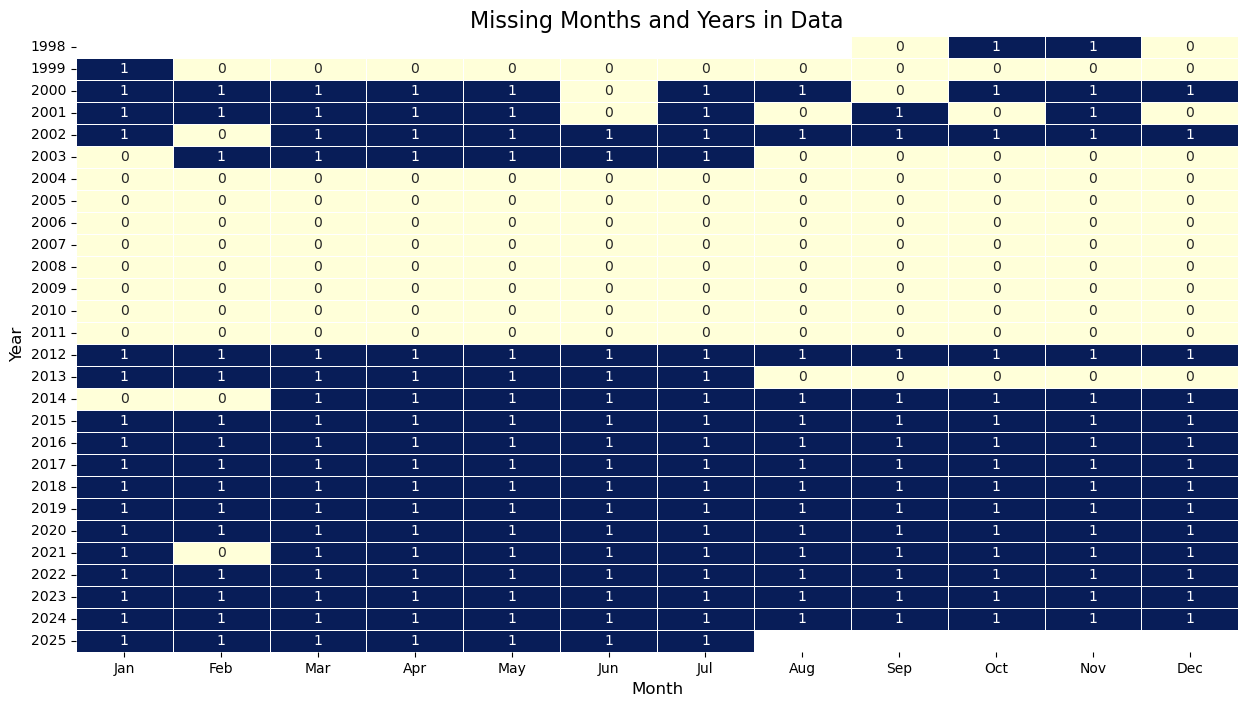

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

# ตั้งค่าขนาดภาพและชื่อ
plt.figure(figsize=(15, 8))
plt.title('Missing Months and Years in Data', fontsize=16)

# สร้าง heatmap
sns.heatmap(
    heatmap_data,
    cmap="YlGnBu",  # เปลี่ยนสีตามความชอบ
    linewidths=.5,
    linecolor='white',
    annot=True,
    fmt='g',
    cbar=False  # ไม่แสดงแถบสี
)

# ตั้งชื่อแกน x และ y
plt.xlabel('Month', fontsize=12)
plt.ylabel('Year', fontsize=12)

# กำหนดชื่อเดือน
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(np.arange(12) + 0.5, labels=month_labels)

plt.yticks(rotation=0)

plt.show()

# Processed data copy from pdf

In [1]:
import pandas as pd

In [25]:
data = []
with open('./numbers.txt', 'r') as f:
    for line in f:
        data.append(line.removesuffix('\n'))

data = [float(x) for x in data]
print(data)

new_data = []
for i in range(0,len(data), 3):
    new_data.append((data[i], data[i+1], data[i+2]))

pd.DataFrame(new_data, columns=['avg','now', 'future']).to_csv('./numbers.csv', sep='\t',index=False)

[55.2, 44.7, 65.7, 54.2, 43.9, 64.4, 53.0, 42.9, 63.0, 51.9, 41.9, 61.8, 50.6, 40.8, 60.4, 49.8, 39.9, 59.3]
